In [1]:
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import learning_curve,RepeatedKFold

from sklearn.pipeline import make_pipeline
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from scipy import stats
from scipy.special import boxcox1p
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso,LassoCV
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet

from sklearn.feature_selection import SelectFromModel
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer,quantile_transform,PowerTransformer
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler

from sklearn.manifold import TSNE

%matplotlib inline

In [2]:

#dataframe final
df_final = pd.read_csv("../data/DF_train400noChangeContact_skempiAB_modeller_final.csv",index_col=0)


pdb_names = df_final.index
features_names = df_final.drop('ddG_exp',axis=1).columns
df_final.shape

(1392, 463)

In [3]:
# Split train and independent test data

X_train, X_test, y_train, y_test = train_test_split(df_final.drop('ddG_exp',axis=1), df_final['ddG_exp'], 
                                                    test_size=0.2, random_state=13)                                               

/home/vilion/miniconda3/envs/bio/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/vilion/miniconda3/envs/bio/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


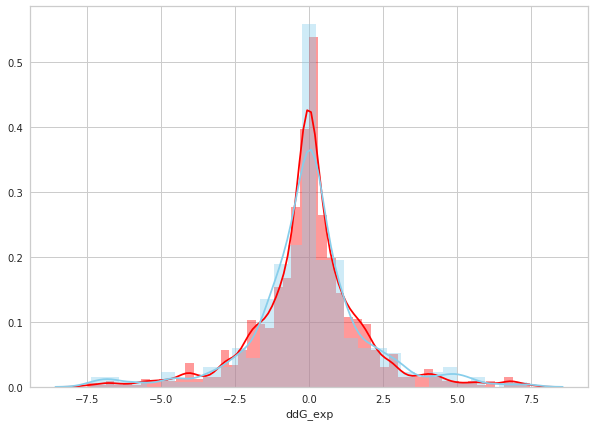

In [4]:
f, ax = plt.subplots(figsize=(10, 7))

sns.distplot(y_train, color="red", label="ddG_exp_train");
sns.distplot(y_test, color="skyblue", label="ddG_exp_test");



 mu = 0.00 and sigma = 1.88



/home/vilion/miniconda3/envs/bio/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


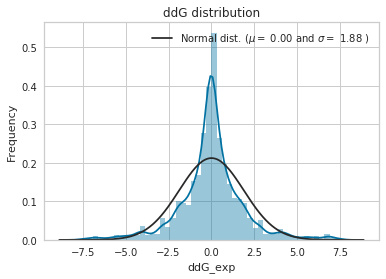

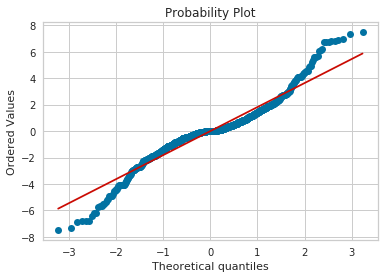

In [5]:
sns.distplot(y_train, fit=stats.norm);

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('ddG distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

# probably need to transform target variable

## Correlation

In [6]:
# join train data for Exploratory analisis of training data
train = X_train.join(y_train)

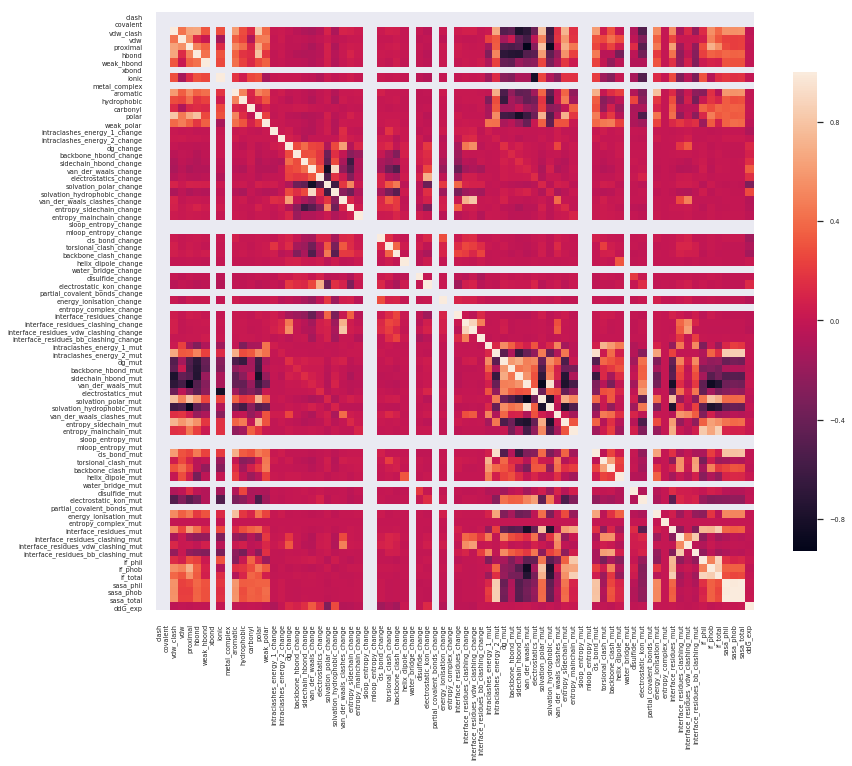

In [7]:
sns.set(font_scale=0.6)

#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(14, 11))
sns.heatmap(corrmat, square=True,cbar_kws={"shrink": .8});

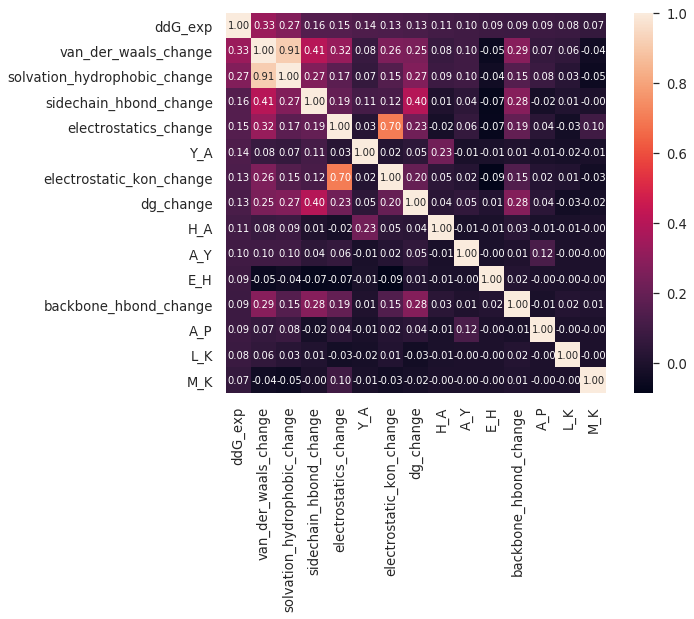

In [11]:
sns.set(font_scale=1.2)
corrmat = train.corr()


#top 10. correlation matrix
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'ddG_exp')['ddG_exp'].index
cm = np.corrcoef(train[cols].values.T)

f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values);
#plt.show()

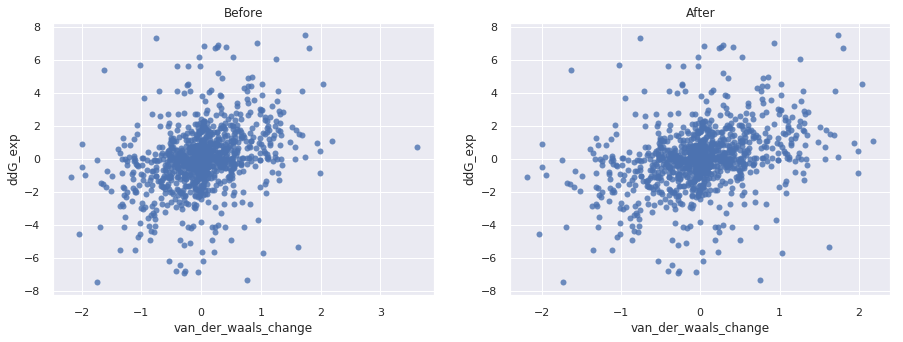

In [7]:
sns.set(font_scale=1)

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['van_der_waals_change'], y=train['ddG_exp'], fit_reg=False).set_title("Before")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train = train.drop(train[(train['van_der_waals_change']>3)].index)
g = sns.regplot(x=train['van_der_waals_change'], y=train['ddG_exp'], fit_reg=False).set_title("After")

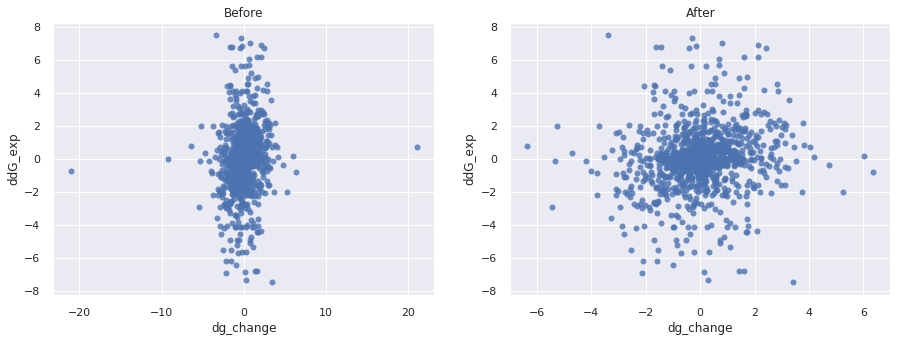

In [8]:
sns.set(font_scale=1)

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['dg_change'], y=train['ddG_exp'], fit_reg=False).set_title("Before")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train = train.drop(train[(train['dg_change'].abs()>8)].index)
g = sns.regplot(x=train['dg_change'], y=train['ddG_exp'], fit_reg=False).set_title("After")

### NO missing values, skip this dataprocess

## 

### Feature engeenering, checking interaction of sift contact with the highest correlated energetic feature
In order to treat this dataset, first I will check if adding interactions betwen some features improve corr, next i will check for skewess features. Finally i will write a custom transform class for every step.

In [9]:
y_train = train['ddG_exp']
X_train = train.drop('ddG_exp',axis=1)

### Check corr of new features

In [17]:
features_interaction_contactVDW = X_train.iloc[:,:400].mul(X_train["van_der_waals_change"],axis=0)# funciona mucho mejor
features_interaction_contactVDW.columns = features_interaction_contactVDW.columns.str[:]+"_vdw_change_interaction"


In [18]:
corr_matrix = features_interaction_contactVDW.corrwith(y_train,axis=0)#.abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
print(corr_matrix.sort_values(ascending=False).round(6))

Y_N_vdw_change_interaction    0.330522
W_Y_vdw_change_interaction    0.308587
Y_Y_vdw_change_interaction    0.303129
Y_D_vdw_change_interaction    0.302706
Y_S_vdw_change_interaction    0.294665
Y_G_vdw_change_interaction    0.279606
G_Y_vdw_change_interaction    0.270585
D_Y_vdw_change_interaction    0.269440
N_N_vdw_change_interaction    0.252998
Y_W_vdw_change_interaction    0.247330
G_G_vdw_change_interaction    0.244865
R_N_vdw_change_interaction    0.239659
N_Y_vdw_change_interaction    0.237040
S_R_vdw_change_interaction    0.234862
K_N_vdw_change_interaction    0.232758
H_N_vdw_change_interaction    0.231960
L_Y_vdw_change_interaction    0.230340
Y_V_vdw_change_interaction    0.225009
R_T_vdw_change_interaction    0.220051
S_S_vdw_change_interaction    0.220007
G_N_vdw_change_interaction    0.218718
K_Y_vdw_change_interaction    0.217528
L_D_vdw_change_interaction    0.217459
K_W_vdw_change_interaction    0.217406
R_S_vdw_change_interaction    0.215568
S_W_vdw_change_interactio

### Check skewness

In [19]:
skew_features = X_train.skew().sort_values(ascending=False)
skew_features

E_L                                      33.301652
M_H                                      33.301652
N_C                                      33.301652
V_L                                      33.301652
G_C                                      33.301652
P_L                                      33.301652
M_T                                      33.301652
K_P                                      33.301652
H_W                                      33.301652
M_K                                      33.301652
M_A                                      33.301652
M_Y                                      33.301652
M_I                                      33.301652
M_D                                      33.301652
K_C                                      33.301652
P_P                                      32.761469
Q_C                                      32.399804
E_H                                      32.033324
M_S                                      31.976192
H_T                            

### Check features by percetange of zero values

In [20]:
overfit = []
for i in X_train.columns:
    counts = X_train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X_train) * 100 >90.:
        overfit.append(i)
overfit

['A_A',
 'A_C',
 'A_D',
 'A_E',
 'A_F',
 'A_H',
 'A_K',
 'A_L',
 'A_M',
 'A_N',
 'A_P',
 'A_Q',
 'A_R',
 'A_S',
 'A_T',
 'A_V',
 'A_W',
 'A_Y',
 'C_A',
 'C_C',
 'C_D',
 'C_E',
 'C_F',
 'C_G',
 'C_H',
 'C_I',
 'C_K',
 'C_L',
 'C_M',
 'C_N',
 'C_P',
 'C_Q',
 'C_R',
 'C_S',
 'C_T',
 'C_V',
 'C_W',
 'C_Y',
 'D_A',
 'D_C',
 'D_F',
 'D_I',
 'D_M',
 'D_P',
 'D_V',
 'D_W',
 'E_A',
 'E_C',
 'E_D',
 'E_E',
 'E_F',
 'E_H',
 'E_I',
 'E_K',
 'E_L',
 'E_M',
 'E_P',
 'E_Q',
 'E_S',
 'E_V',
 'E_W',
 'E_Y',
 'F_C',
 'F_D',
 'F_E',
 'F_F',
 'F_H',
 'F_I',
 'F_K',
 'F_L',
 'F_M',
 'F_V',
 'F_W',
 'F_Y',
 'G_A',
 'G_C',
 'G_F',
 'G_M',
 'G_P',
 'G_V',
 'G_W',
 'H_A',
 'H_C',
 'H_E',
 'H_F',
 'H_H',
 'H_I',
 'H_L',
 'H_M',
 'H_P',
 'H_S',
 'H_T',
 'H_V',
 'H_W',
 'H_Y',
 'I_A',
 'I_C',
 'I_D',
 'I_E',
 'I_F',
 'I_G',
 'I_H',
 'I_I',
 'I_K',
 'I_L',
 'I_M',
 'I_N',
 'I_P',
 'I_Q',
 'I_R',
 'I_S',
 'I_V',
 'I_W',
 'I_Y',
 'K_C',
 'K_D',
 'K_E',
 'K_F',
 'K_H',
 'K_I',
 'K_K',
 'K_L',
 'K_M',
 'K_P',
 'K_Q',


### make custom transformers for preprocess in pipeline

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeaturesInteractions(BaseEstimator, TransformerMixin):
    
    #Class constructor method that takes ..
    def __init__(self, interaction1, interaction2 ):
        self.interaction1 = interaction1
        self.interaction2 = interaction2
        
    #Return self nothing else to do here
    def fit( self, X, y = None  ):
        
        return self
    
    def transform(self, X , y=None ):
        
        X_interactions = X.loc[:,self.interaction1].mul(X[self.interaction2],axis=0)
        X_interactions.columns = X_interactions.columns.values+'/{}'.format(self.interaction2)
        # set columns names
        
        X = X.join(X_interactions)
        
        return X
    
class SkewTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold=0.6, method='quantile'):
        self.threshold = threshold
        self.method = method
        
    #Return self nothing else to do here
    def fit(self, X, y = None  ):
        skewes_ = X.skew().sort_values(ascending=False)
        self.skew_features = skewes_[skewes_.abs() > self.threshold]
        
        if self.method == 'quantile':
            self.t = QuantileTransformer(output_distribution="normal",random_state=13)
            self.t.fit(X[self.skew_features.index])
        
        return self
    
    def transform(self, X, y=None):
        
        X[self.skew_features.index] = self.t.transform(X[self.skew_features.index])
        
        return X
        
class ZeroThreshold(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold=90.):
        self.threshold = threshold
    
    
    def fit(self, X, y = None  ):
        
        self.feature_names = X.columns
        self.overfit = []
        for i in X.columns:
            counts = X[i].value_counts()
            zeros = counts.iloc[0]
            if zeros / len(X) * 100 >self.threshold:
                self.overfit.append(i)
        
        return self
    
    def transform(self, X, y=None):
        
        X.drop(self.overfit,axis=1,inplace=True)
        
        return X



# Modeling

In [11]:

X_train.shape,y_train.shape,X_test.shape,y_test.shape

((1109, 462), (1109,), (279, 462), (279,))

In [23]:
#1)  ORIGINAL
## Pipeline preprocessing
interactions = FeaturesInteractions(interaction1=X_train.columns[:400].tolist(),interaction2="van_der_waals_change")
skewness = SkewTransformer(threshold=0.6,method='quantile')
zeroth = ZeroThreshold(threshold=90.)

scaler = MinMaxScaler()


#2)
linear_model = LinearRegression()
#3) Crear pipeline
pipeline1 = make_pipeline(interactions,skewness,zeroth,scaler,linear_model)

# Use transformed target regressor
regr_trans = TransformedTargetRegressor(regressor=pipeline1, 
                                        transformer=QuantileTransformer(output_distribution='normal',random_state=13))


# grid params
# param_grid = {"regressor__linearregression__fit_intercept":[True,False],"regressor__linearregression__normalize":[True,False]}
#              #'regressor__variancethreshold__threshold':[0.001,0]}
    
param_grid = {"linearregression__fit_intercept":[True,False],"linearregression__normalize":[True,False]}
             #'regressor__variancethreshold__threshold':[0.001,0]}
cv = RepeatedKFold(n_splits=10,n_repeats=5,random_state=13)

# Instantiate the grid search model
grid1 = GridSearchCV(pipeline1, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='neg_mean_squared_error',return_train_score=True)

grid1.fit(X_train,y_train)

Fitting 50 folds for each of 4 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  7.4min finished
/home/vilion/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x7f80581f8550>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('featuresinteractions', FeaturesInteractions(interaction1=['A_A', 'A_C', 'A_D', 'A_E', 'A_F', 'A_G', 'A_H', 'A_I', 'A_K', 'A_L', 'A_M', 'A_N', 'A_P', 'A_Q', 'A_R', 'A_S', 'A_T', 'A_V', 'A_W', 'A_Y', 'C_A', 'C_C', 'C_D', 'C_E', 'C_F', 'C_G', 'C_H', 'C_I', 'C_K', 'C_L', 'C_M', 'C_N', 'C_P', 'C...ression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score=True, scoring=['neg_mean_squared_error', 'r2'],
       verbose=5)

In [24]:
# index of best scores
rmse_bestCV_test_index = grid1.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid1.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid1.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid1.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid1.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid1.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid1.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid1.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid1.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid1.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid1.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid1.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('DIFF RMSE {}'.format(np.sqrt(-rmse_bestCV_test_score)-np.sqrt(-rmse_bestCV_train_score)))
print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid1.best_params_)
y_test_pred = grid1.best_estimator_.predict(X_test)
y_train_pred = grid1.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test)[0][1]))
print('R2 test',r2_score(y_test,y_test_pred))
print('R2 train',r2_score(y_train,y_train_pred))

CV test RMSE 82749714142.853256 +/- 216469495415.802490
CV train RMSE 0.701567 +/- 0.276591
DIFF RMSE 82749714142.15169
CV test r2 -1469299490495236145152.000000 +/- 9975142579280346611712.000000
CV train r2 0.860784 +/- 0.021366
1.4692994904952361e+21
 {'linearregression__fit_intercept': False, 'linearregression__normalize': True}

RMSE for test dataset: 996.22
RMSE for train dataset: 0.77
pearson corr  -0.048671
R2 test -250196.64700007363
R2 train 0.8313601845969885


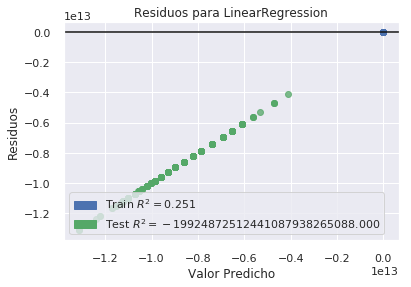

In [60]:
visualizer = ResidualsPlot(grid1.best_estimator_,title='Residuos para LinearRegression',hist=False)

visualizer.fit(X_train, y_train.values.ravel())  # Fit the training data to the model
visualizer.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

visualizer.finalize()
visualizer.ax.set_xlabel('Valor Predicho')
visualizer.ax.set_ylabel('Residuos')

plt.savefig("LinearRegression_R2_train15.png",dpi=600,bbox_inches="tight")

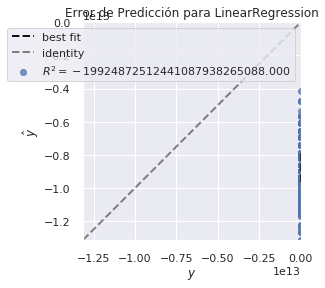

In [61]:
perror = PredictionError(grid1.best_estimator_, title='Error de Predicción para LinearRegression')

perror.fit(X_train, y_train.values.ravel())  # Fit the training data to the visualizer
perror.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

perror.finalize()
plt.savefig("LinearRegression_PredictionError_train15.png",dpi=600,bbox_inches="tight")

#g = perror.poof()

In [62]:
full_data = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

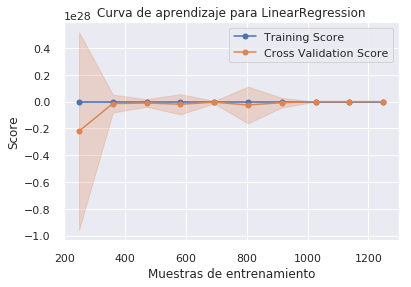

In [63]:

viz = LearningCurve(grid1.best_estimator_, cv=cv, n_jobs=-1,scoring='neg_mean_squared_error',
                    train_sizes=np.linspace(0.2, 1.0, 10),title='Curva de aprendizaje para LinearRegression')
viz.fit(full_data, y_full)

viz.finalize()

viz.ax.set_xlabel('Muestras de entrenamiento')
viz.ax.set_ylabel('Score')

plt.savefig("LinearRegression_LearningCurve_train15.png",dpi=600,bbox_inches="tight")

#viz.poof()

In [64]:
print("RMSE CV Train {}".format(np.sqrt(-viz.train_scores_mean_[-1])))
print("RMSE CV Test {}".format(np.sqrt(-viz.test_scores_mean_[-1])))

RMSE CV Train 1.6238052725321324
RMSE CV Test 1.7541193114035778


# l2 regularization or Ridge, default


In [13]:
#1)  ORIGINAL
## Pipeline preprocessing
interactions = FeaturesInteractions(interaction1=X_train.columns[:15].tolist(),interaction2="van_der_waals_change")
skewness = SkewTransformer(threshold=0.6,method='quantile')
zeroth = ZeroThreshold(threshold=90.)

scaler = MinMaxScaler()
#2)
linear_model = Ridge()
#3) Crear pipeline
pipeline2 = make_pipeline(interactions,skewness,zeroth,scaler,linear_model)

# Use transformed target regressor
regr_trans2 = TransformedTargetRegressor(regressor=pipeline2, 
                                        transformer=QuantileTransformer(output_distribution='normal',random_state=13))


# grid params
# param_grid = {"regressor__ridge__alpha":[0.5,1.2,2],"regressor__ridge__normalize":[True,False],"regressor__ridge__fit_intercept":[True,False]}
#              #'regressor__variancethreshold__threshold':[0.001,0]}
param_grid = {"ridge__alpha":[0.1,0.2],"ridge__normalize":[True,False],"ridge__fit_intercept":[True,False]}
             #'regressor__variancethreshold__threshold':[0.001,0]}

cv = RepeatedKFold(n_splits=10,n_repeats=5,random_state=13)

# Instantiate the grid search model
grid2 = GridSearchCV(pipeline2, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='neg_mean_squared_error',return_train_score=True)

grid2.fit(X_train,y_train)

Fitting 50 folds for each of 8 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


NameError: name 'overfit' is not defined

In [79]:
# index of best scores
rmse_bestCV_test_index = grid2.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid2.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid2.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid2.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid2.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid2.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid2.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid2.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid2.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid2.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid2.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid2.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('DIFF RMSE {}'.format(np.sqrt(-rmse_bestCV_test_score)-np.sqrt(-rmse_bestCV_train_score)))

print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid2.best_params_)
y_test_pred = grid2.best_estimator_.predict(X_test)
y_train_pred = grid2.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test.values.ravel())[0][1]))
print('R2 test',r2_score(y_test,y_test_pred))
print('R2 train',r2_score(y_train,y_train_pred))

CV test RMSE 1.744879 +/- 0.854172
CV train RMSE 1.622925 +/- 0.273704
DIFF RMSE 0.12195436550850336
CV test r2 0.133043 +/- 0.091135
CV train r2 0.254909 +/- 0.011088
0.12186653018802993
 {'ridge__alpha': 0.2, 'ridge__fit_intercept': True, 'ridge__normalize': True}

RMSE for test dataset: 1.76
RMSE for train dataset: 1.66
pearson corr  0.546646
R2 test 0.21705321192128324
R2 train 0.21897585995872548


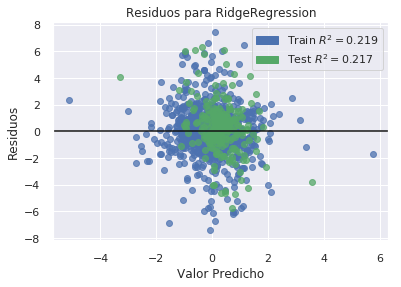

In [80]:
visualizer = ResidualsPlot(grid2.best_estimator_,title='Residuos para RidgeRegression',hist=False)

visualizer.fit(X_train, y_train.values.ravel())  # Fit the training data to the model
visualizer.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

visualizer.finalize()
visualizer.ax.set_xlabel('Valor Predicho')
visualizer.ax.set_ylabel('Residuos')

plt.savefig("RidgeRegression_R2_train15.png",dpi=600,bbox_inches="tight")

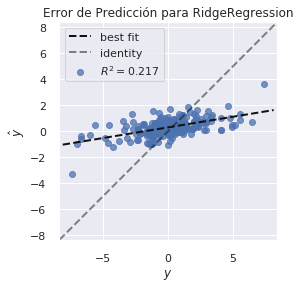

In [81]:
perror = PredictionError(grid2.best_estimator_, title='Error de Predicción para RidgeRegression')

perror.fit(X_train, y_train.values.ravel())  # Fit the training data to the visualizer
perror.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

perror.finalize()
plt.savefig("RidgeRegression_PredictionError_train15.png",dpi=600,bbox_inches="tight")

#g = perror.poof()


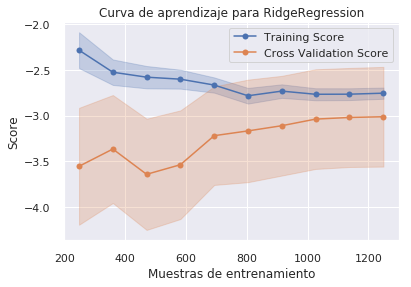

In [82]:
viz = LearningCurve(grid2.best_estimator_, cv=cv, n_jobs=-1,scoring='neg_mean_squared_error',
                    train_sizes=np.linspace(0.2, 1.0, 10),title='Curva de aprendizaje para RidgeRegression')
viz.fit(full_data, y_full)

viz.finalize()

viz.ax.set_xlabel('Muestras de entrenamiento')
viz.ax.set_ylabel('Score')

plt.savefig("RidgeRegression_LearningCurve_train15.png",dpi=600,bbox_inches="tight")

#viz.poof()

# LASSO

In [83]:
#1)  ORIGINAL

## Pipeline preprocessing
interactions = FeaturesInteractions(interaction1=X_train.columns[:15].tolist(),interaction2="van_der_waals_change")
skewness = SkewTransformer(threshold=0.6,method='quantile')
zeroth = ZeroThreshold(threshold=90.)

scaler = MinMaxScaler()


#2)
linear_model = Lasso()
#3) Crear pipeline
pipeline3 = make_pipeline(interactions,skewness,zeroth, scaler,linear_model)

# Use transformed target regressor
regr_trans3 = TransformedTargetRegressor(regressor=pipeline3, 
                                        transformer=QuantileTransformer(output_distribution='normal',random_state=13))


# grid params
# param_grid = {"regressor__lasso__alpha":[0.0004,0.0003,0.0002],"regressor__lasso__normalize":[True,False],
#               "regressor__lasso__fit_intercept":[False,True]}

param_grid = {"lasso__alpha":[0.0008,0.00075],"lasso__normalize":[True],
              "lasso__fit_intercept":[True]}


cv = RepeatedKFold(n_splits=10,n_repeats=5,random_state=13)

# Instantiate the grid search model
grid3 = GridSearchCV(pipeline3, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='neg_mean_squared_error',return_train_score=True)

grid3.fit(X_train,y_train)

Fitting 50 folds for each of 2 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.2s finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x7f825ad26ef0>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('featuresinteractions', FeaturesInteractions(interaction1=['clash', 'covalent', 'vdw_clash', 'vdw', 'proximal', 'hbond', 'weak_hbond', 'xbond', 'ionic', 'metal_complex', 'aromatic', 'hydrophobic', 'carbonyl', 'polar', 'weak_polar'],
           interaction2='van_der_waals_change')), ('skewtra...e=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'lasso__alpha': [0.0008, 0.00075], 'lasso__normalize': [True], 'lasso__fit_intercept': [True]},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score=True, scoring=['neg_mean_squared_error', 'r2'],
       verbose=5)

In [84]:
# index of best scores
rmse_bestCV_test_index = grid3.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid3.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid3.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid3.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid3.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid3.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid3.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid3.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid3.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid3.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid3.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid3.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('DIFF RMSE {}'.format(np.sqrt(-rmse_bestCV_test_score)-np.sqrt(-rmse_bestCV_train_score)))

print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid3.best_params_)
y_test_pred = grid3.best_estimator_.predict(X_test)
y_train_pred = grid3.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test.values.ravel())[0][1]))
print('R2 test',r2_score(y_test,y_test_pred))
print('R2 train',r2_score(y_train,y_train_pred))

CV test RMSE 1.730437 +/- 0.851654
CV train RMSE 1.658083 +/- 0.276962
DIFF RMSE 0.07235413674285152
CV test r2 0.147458 +/- 0.092319
CV train r2 0.222270 +/- 0.011293
0.07481202389869435
 {'lasso__alpha': 0.0008, 'lasso__fit_intercept': True, 'lasso__normalize': True}

RMSE for test dataset: 1.68
RMSE for train dataset: 1.66
pearson corr  0.566612
R2 test 0.284624903170804
R2 train 0.2159755330786972


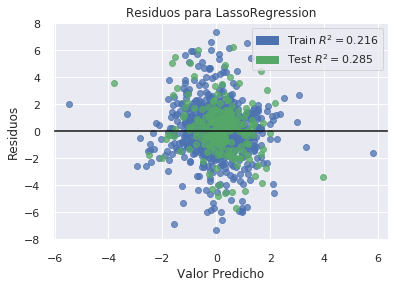

In [85]:
visualizer = ResidualsPlot(grid3.best_estimator_,title='Residuos para LassoRegression',hist=False)

visualizer.fit(X_train, y_train.values.ravel())  # Fit the training data to the model
visualizer.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

visualizer.finalize()
visualizer.ax.set_xlabel('Valor Predicho')
visualizer.ax.set_ylabel('Residuos')

plt.savefig("LassoRegression_R2_train15.png",dpi=600,bbox_inches="tight")

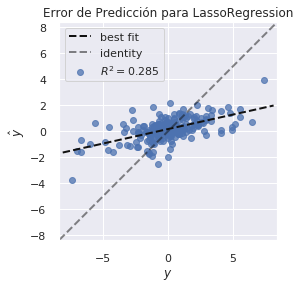

In [86]:
perror = PredictionError(grid3.best_estimator_, title='Error de Predicción para LassoRegression')

perror.fit(X_train, y_train.values.ravel())  # Fit the training data to the visualizer
perror.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

perror.finalize()
plt.savefig("LassoRegression_PredictionError_train15.png",dpi=600,bbox_inches="tight")

#g = perror.poof()

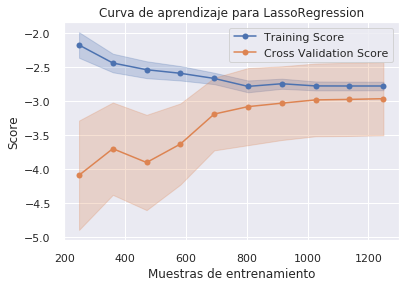

In [87]:
viz = LearningCurve(grid3.best_estimator_, cv=cv, n_jobs=-1,scoring='neg_mean_squared_error',
                    train_sizes=np.linspace(0.2, 1.0, 10),title='Curva de aprendizaje para LassoRegression')
viz.fit(full_data, y_full)

viz.finalize()

viz.ax.set_xlabel('Muestras de entrenamiento')
viz.ax.set_ylabel('Score')

plt.savefig("LassoRegression_LearningCurve_train15.png",dpi=600,bbox_inches="tight")

#viz.poof()

# ElasticNet

In [103]:
#1)  ORIGINAL

## Pipeline preprocessing
interactions = FeaturesInteractions(interaction1=X_train.columns[:15].tolist(),interaction2="van_der_waals_change")
skewness = SkewTransformer(threshold=0.6,method='quantile')
zeroth = ZeroThreshold(threshold=90.)

scaler = MinMaxScaler()


#2)
linear_model = ElasticNet()
#3) Crear pipeline
pipeline4 = make_pipeline(interactions,skewness,zeroth, scaler,linear_model)

# Use transformed target regressor
regr_trans4 = TransformedTargetRegressor(regressor=pipeline4, 
                                        transformer=QuantileTransformer(output_distribution='normal',random_state=13))


# grid params
# param_grid = {"regressor__elasticnet__alpha":[0.0004,0.0003,0.0002],'regressor__elasticnet__l1_ratio':[1,0.9,1.1],
#               "regressor__elasticnet__normalize":[True],"regressor__elasticnet__fit_intercept":[True]}

param_grid = {"elasticnet__alpha":[0.0007,0.0009,0.0008],'elasticnet__l1_ratio':[1,0.1,2],
              "elasticnet__normalize":[True],"elasticnet__fit_intercept":[True]}
cv = RepeatedKFold(n_splits=10,n_repeats=5,random_state=13)

# Instantiate the grid search model
grid4 = GridSearchCV(pipeline4, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='neg_mean_squared_error',return_train_score=True)

grid4.fit(X_train,y_train)

Fitting 50 folds for each of 9 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  1.0min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x7f825112da20>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('featuresinteractions', FeaturesInteractions(interaction1=['clash', 'covalent', 'vdw_clash', 'vdw', 'proximal', 'hbond', 'weak_hbond', 'xbond', 'ionic', 'metal_complex', 'aromatic', 'hydrophobic', 'carbonyl', 'polar', 'weak_polar'],
           interaction2='van_der_waals_change')), ('skewtra...alse, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'elasticnet__alpha': [0.0007, 0.0009, 0.0008], 'elasticnet__l1_ratio': [1, 0.1, 2], 'elasticnet__normalize': [True], 'elasticnet__fit_intercept': [True]},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score=True, scoring=['neg_mean_squared_error', 'r2'],
       verbose=5)

In [104]:
# index of best scores
rmse_bestCV_test_index = grid4.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid4.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid4.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid4.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid4.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid4.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid4.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid4.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid4.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid4.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid4.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid4.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('DIFF RMSE {}'.format(np.sqrt(-rmse_bestCV_test_score)-np.sqrt(-rmse_bestCV_train_score)))

print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid4.best_params_)
y_test_pred = grid4.best_estimator_.predict(X_test)
y_train_pred = grid4.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test.values.ravel())[0][1]))
print('R2 test',r2_score(y_test,y_test_pred))
print('R2 train',r2_score(y_train,y_train_pred))

CV test RMSE 1.730437 +/- 0.851654
CV train RMSE 1.656214 +/- 0.277319
DIFF RMSE 0.07422273722599271
CV test r2 0.147458 +/- 0.092319
CV train r2 0.224024 +/- 0.011324
0.07656608468076437
 {'elasticnet__alpha': 0.0008, 'elasticnet__fit_intercept': True, 'elasticnet__l1_ratio': 1, 'elasticnet__normalize': True}

RMSE for test dataset: 1.68
RMSE for train dataset: 1.66
pearson corr  0.566612
R2 test 0.284624903170804
R2 train 0.2159755330786972


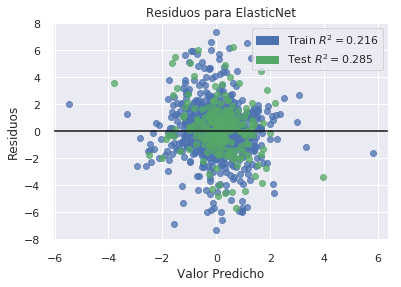

In [105]:
visualizer = ResidualsPlot(grid4.best_estimator_,title='Residuos para ElasticNet',hist=False)

visualizer.fit(X_train, y_train.values.ravel())  # Fit the training data to the model
visualizer.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

visualizer.finalize()
visualizer.ax.set_xlabel('Valor Predicho')
visualizer.ax.set_ylabel('Residuos')

plt.savefig("ElasticNet_R2_train15.png",dpi=600,bbox_inches="tight")

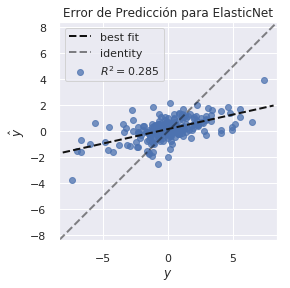

In [106]:
perror = PredictionError(grid4.best_estimator_, title='Error de Predicción para ElasticNet')

perror.fit(X_train, y_train.values.ravel())  # Fit the training data to the visualizer
perror.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

perror.finalize()
plt.savefig("ElasticNet_PredictionError_train15.png",dpi=600,bbox_inches="tight")

#g = perror.poof()

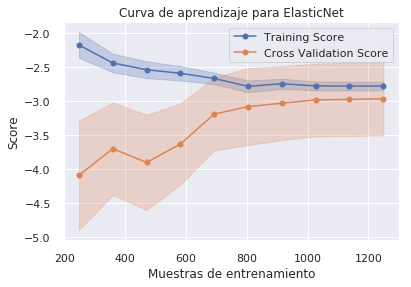

In [107]:
viz = LearningCurve(grid4.best_estimator_, cv=cv, n_jobs=-1,scoring='neg_mean_squared_error',
                    train_sizes=np.linspace(0.2, 1.0, 10),title='Curva de aprendizaje para ElasticNet')
viz.fit(full_data, y_full)

viz.finalize()

viz.ax.set_xlabel('Muestras de entrenamiento')
viz.ax.set_ylabel('Score')

plt.savefig("ElasticNet_LearningCurve_train15.png",dpi=600,bbox_inches="tight")

#viz.poof()

In [140]:
# Save best lienar model

In [108]:
final_linear = grid4.best_estimator_.fit(full_data,y_full)
# save final model

joblib.dump(final_linear, 'elasticNet_train15skempiAB_FINAL.pkl')

['elasticNet_train15skempiAB_FINAL.pkl']